# **Forecasting Realized Volatility**

In contrast to *implied volatility* (IV), which reflects the market’s expectation of future uncertainty, *realized volatility* (RV) corresponds to the volatility that actually materializes over a given horizon. From a modeling perspective, RV exhibits strong persistence and clustering, making it more forecastable than IV or returns themselves.

## Why Forecast Realized Volatility?

Forecasting RV is valuable for several reasons in both trading and risk management:

- **Volatility Trading & IV–RV Strategies**  
  Accurate RV forecasts allow us to identify mispricings between implied and realized volatility.  
  For example, if IV is significantly higher than the forecasted RV, it may indicate an opportunity to short volatility and harvest the volatility risk premium (VRP).

- **Position Sizing**  
  Forecasted volatility can be used to dynamically scale positions: larger sizes in calm regimes, smaller sizes in volatile markets.  
  This volatility targeting improves risk-adjusted returns.

- **Risk Management (Stop Loss / Take Profit)**  
  RV forecasts help set realistic expectations for daily or monthly moves, which can inform stop-loss and take-profit levels in directional strategies.

- **Cross-asset & Relative Value Applications**  
  Comparing volatility forecasts across assets or maturities enables relative value trades (e.g., long vol where it is forecasted to rise, short vol where it is forecasted to fall).

---

By systematically modeling and forecasting RV — using approaches such as HAR models, GARCH-type processes, or machine learning — we can generate signals that are not only academically robust but also directly actionable in trading strategies.


The notebook is structured as follows:

1. [Read & Prepare Data](#read_data)
2. [Volatility Estimators](#real-vol)
   - [3.1. Historical (close-to-close): 10D, 21D, 100D](#trade-execution-setup)
   - [3.2. Range-based (OHLC): Parkinson, GK, Rogers-Satchel, Yang Zhang](#trade-execution-setup)
2. [Stylized facts of realized volatility](#real-vol)
3. [Predictors of realized volatility](#real-vol)
4. [Forecasting Models](#real-vol)
5. [Evaluation: Walkk forward with cross val, RMSE vs QLIKE, plotting residuals, refitting models every months](#real-vol)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# **1. Read & Prepare Data**

For this analysis we are going to consider daily S&P500 OHLC data from Yahoo finance from `2018` to `2025` and prepare it for analysis.

In [41]:
spx = yf.download("^GSPC", start="2018-01-01", auto_adjust=True)
spx

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2018-01-02,2695.810059,2695.889893,2682.360107,2683.729980,3397430000
2018-01-03,2713.060059,2714.370117,2697.770020,2697.850098,3544030000
2018-01-04,2723.989990,2729.290039,2719.070068,2719.310059,3697340000
2018-01-05,2743.149902,2743.449951,2727.919922,2731.330078,3239280000
2018-01-08,2747.709961,2748.510010,2737.600098,2742.669922,3246160000
...,...,...,...,...,...
2025-10-20,6735.129883,6744.350098,6690.049805,6690.049805,4672170000
2025-10-21,6735.350098,6752.160156,6722.029785,6736.750000,5245020000


In [42]:
spx.isna().sum()

Price   Ticker
Close   ^GSPC     0
High    ^GSPC     0
Low     ^GSPC     0
Open    ^GSPC     0
Volume  ^GSPC     0
dtype: int64

In [43]:
spx["ret"] = np.log(spx["Close"] / spx["Close"].shift(1))
spx = spx.dropna()
spx

Price,Close,High,Low,Open,Volume,ret
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,
2018-01-03,2713.060059,2714.370117,2697.770020,2697.850098,3544030000,0.006378
2018-01-04,2723.989990,2729.290039,2719.070068,2719.310059,3697340000,0.004021
2018-01-05,2743.149902,2743.449951,2727.919922,2731.330078,3239280000,0.007009
2018-01-08,2747.709961,2748.510010,2737.600098,2742.669922,3246160000,0.001661
2018-01-09,2751.290039,2759.139893,2747.860107,2751.149902,3467460000,0.001302
...,...,...,...,...,...,...
2025-10-20,6735.129883,6744.350098,6690.049805,6690.049805,4672170000,0.010616
2025-10-21,6735.350098,6752.160156,6722.029785,6736.750000,5245020000,0.000033


Text(0.5, 1.0, 'Log Returns')

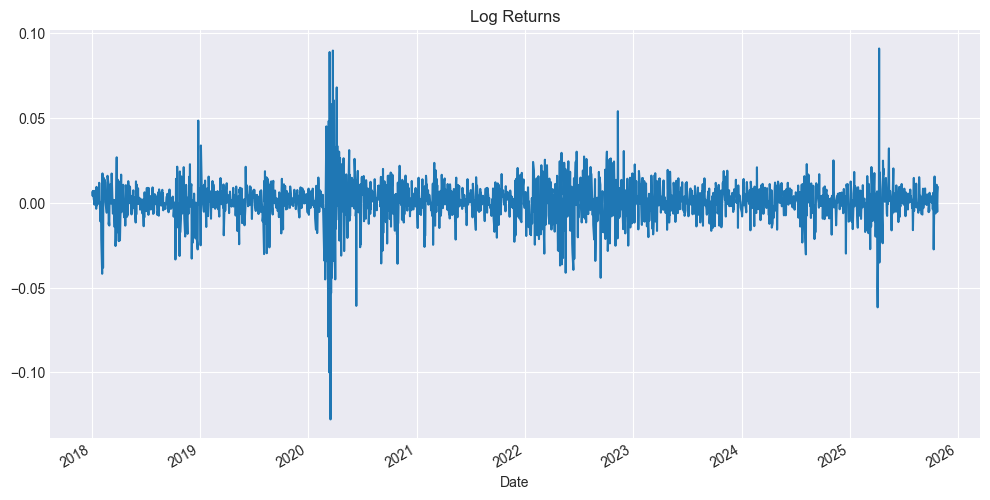

In [47]:
spx["ret"].plot(figsize=(12, 6))
plt.title("Log Returns")

# **2. Volatility Estimators**

Volatility is a *latent* quantity — it cannot be observed directly. To evaluate forecasts and build predictors, we need to construct **proxies** from price data. Different estimators trade off bias vs efficiency depending on the sampling frequency and data available.

### 2.1 Historical / Close-to-Close
- Simplest approach: use squared daily returns aggregated over a horizon.  
- Easy to compute, very long history available.  
- Drawback: ignores intraday variation and can be noisy.

$$
RV_{t,H} = \sqrt{\tfrac{252}{H} \sum_{j=1}^H r_{t+j}^2}, 
\quad r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$


In [48]:
def rv_close_to_close(returns, h=21, ann=252):
    var = returns.pow(2).rolling(h).sum() * (ann / h)
    return np.sqrt(var)

In [50]:
spx.loc[:, "rv21_close"] = rv_close_to_close(spx["ret"], h=21)

<Axes: xlabel='Date'>

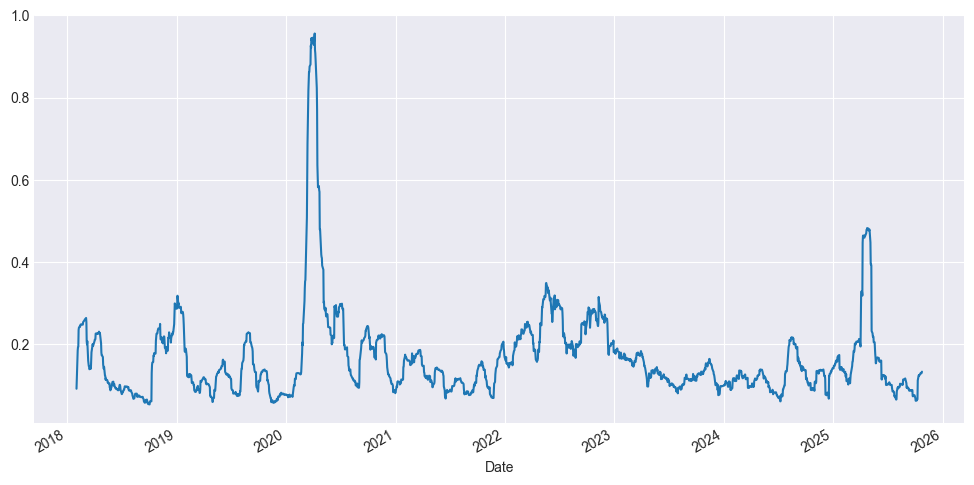

In [52]:
spx["rv21_close"].plot(figsize=(12, 6))

### 2.2 Range-Based Proxies (OHLC)

Instead of relying on closign prices, we can get more infromation from eahc tarding day by considering Open, High, Low, and Closing prices. For that, several RP estimators have been developed over the years each with their own specifity and ttrying to remedy some of issues of teh rpevious eestimatirs.

2.2.1. Parkinson Estimator

The Parkinson Estimator ...



- Use daily high–low–open–close prices.  
- Exploit more information than just closes → lower variance in estimation.  
- Examples:
  - **Parkinson (1980):** uses high–low range.
  - **Garman–Klass (1980):** uses open, high, low, close.
  - **Rogers–Satchell (1991):** handles drift better.
  - **Yang–Zhang (2000):** combines overnight, open–close, and high–low; robust and efficient.

In [54]:
def rv_parkinson(high, low, h=21, ann=252):
    rp = np.log(high / low).pow(2)  # per-day range variance proxy
    var = rp.rolling(h, min_periods=h).sum() * (ann / (4 * np.log(2) * h))
    return np.sqrt(var)

In [55]:
spx.loc[:, "rv21_parkinson"] = rv_parkinson(spx["High"], spx["Low"], h=21)

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_28794/1969298091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spx.loc[:, "rv21_parkinson"] = rv_parkinson(spx["High"], spx["Low"], h=21)


<Axes: xlabel='Date'>

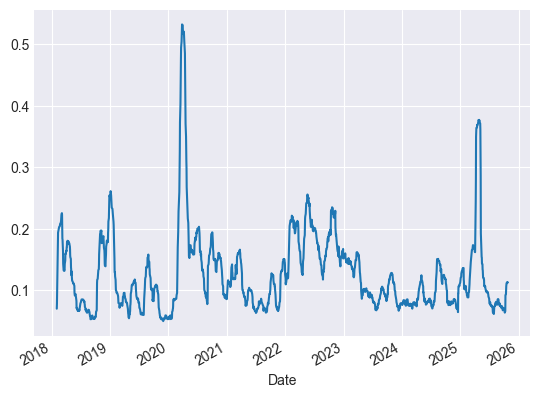

In [56]:
spx["rv21_parkinson"].plot()


---

### 2.3 High-Frequency Realized Measures (if intraday data available)
- Sum of intraday squared returns (5-min, 1-min).  
- Most statistically efficient; can be refined with jump-robust versions (e.g., bipower variation, realized kernels).  
- Data intensive; usually shorter history than daily bars.

---

### **Takeaway**
- For **long horizons / historical backtests** → close-to-close is standard.  
- For **daily OHLC data** → Yang–Zhang is a superior alternative.  
- For **intraday futures data** → realized variance or robust estimators provide the most accurate measure.

# **2. Stylized facts of realized volatility**

Volatility us 

- ACF-PACF of saurred returns (persistence)
- Volatiltiy clusterign & Mean reversion
- Leverage effect
- Overnight vs intraday volatility

# **3. Predictors of realized volatility**

- HAR lags
- ATM 30D IV (or VIX)
- Downisde smei variance 
- VIX term strcuture, VVIX

# **4. Forecast Realized Volatility**

In [ ]:
from abc import ABC, abstractmethod

class BaseRVForecaster(ABC):
    def __init__(self, H=21, name=None):
        self.H = H
        self.name = name or self.__class__.__name__

    @abstractmethod
    def fit(self, returns: pd.Series, rv: pd.Series, **kwargs):
        """Estimate parameters using a TRAIN window (no look-ahead)."""

    def warm_state(self, returns: pd.Series, rv: pd.Series):
        """Update internal state with observed data (no parameter re-fit)."""
        return self

    @abstractmethod
    def forecast(self, as_of_index: pd.DatetimeIndex) -> pd.Series:
        """Return ex-ante H-horizon RV forecast indexed by as_of_index."""


## **4.1 EWMA (Risk Metrics)**

## **4.1 Log HAR-RV**

## **4.1 GARCH family of models (GARCH(1, 1), EGARCH, GJR-GARCH)**

## **4.1 Machine Learning models (Random Forest, XGboost)**

## **4.1 Ensemble Model**

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from arch import arch_model
from sklearn.ensemble import GradientBoostingRegressor

class RVForecaster:
    def __init__(self, returns, rv):
        """
        Parameters
        ----------
        returns : pd.Series
            Daily log returns of the underlying.
        rv : pd.Series
            Realized volatility series (e.g. 21D rolling, annualized).
        """
        self.returns = returns.dropna()
        self.rv = rv.dropna()
    
    # === EWMA ===
    def ewma(self, lam=0.94):
        """RiskMetrics EWMA volatility forecast."""
        sigma2 = 0
        forecasts = []
        for r in self.returns:
            sigma2 = lam * sigma2 + (1 - lam) * r**2
            forecasts.append(np.sqrt(sigma2 * 252))
        return pd.Series(forecasts, index=self.returns.index, name="EWMA")
    
    # === HAR-RV ===
    def har(self, lags=(1,5,22)):
        """HAR-RV model using daily/weekly/monthly realized vol."""
        df = pd.DataFrame({"RV": self.rv})
        for lag in lags:
            df[f"lag{lag}"] = self.rv.shift(lag).rolling(lag).mean()
        df = df.dropna()
        X = sm.add_constant(df[[f"lag{l}" for l in lags]])
        model = OLS(df["RV"], X).fit()
        forecast = model.predict(X)
        return forecast.rename("HAR-RV")
    
    # === GARCH(1,1) ===
    def garch(self):
        """GARCH(1,1) forecast."""
        model = arch_model(self.returns*100, vol="GARCH", p=1, q=1, dist="normal")
        res = model.fit(disp="off")
        forecast = res.forecast(horizon=1).variance.iloc[:,0]**0.5 / 100
        forecast = forecast.rename("GARCH(1,1)")
        return forecast
    
    # === ML (GBM by default) ===
    def ml(self, features, model=None):
        """Forecast RV using ML (GradientBoosting by default)."""
        if model is None:
            model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        X = features.shift(1).dropna()
        y = self.rv.loc[X.index]
        model.fit(X, y)
        forecast = pd.Series(model.predict(X), index=X.index, name="ML-RV")
        return forecast